# Sea ice drift from satellite observations: assessment of resolution and uncertainty of Arctic sea ice drift for large-scale Arctic sea ice transport analyses

Production date: 31-12-2025

Dataset version: 1.0

Produced by: Yoni Verhaegen and Philippe Huybrechts (Vrije Universiteit Brussel)

## 🌍 Use case: Quantifying sea ice transport out of the Arctic basin through Fram Strait in the context of the current global warming

## ❓ Quality assessment question
* **"Is the C3S sea ice drift dataset sufficiently adequate in terms of its spatio-temporal resolution and uncertainty for use in Arctic sea ice mass balance assessments?"**

Sea ice drift derived from satellite observations is a fundamental tool for monitoring changes in polar sea ice dynamics and understanding the impact of climate variability on the Arctic and Antarctic regions. Coinciding with the Arctic warming ratio which is about 4 times the global average, Arctic sea ice has significantly declined in the last several decades. In this context, the ‘Sea ice drift daily gridded data derived from satellite observations’ on the Climate Data Store (CDS), provided by the Ocean and Sea Ice Satellite Application Facility (OSI SAF), offers daily sea ice drift vectors and their associated uncertainties for both hemispheres on a 75 km equal area projection grid. They can be interpreted as sea ice motion: the displacement of sea ice within a certain time period [[1](https://doi.org/10.5194/essd-15-5807-2023)].

The Fram Strait, situated between Greenland and Svalbard, is the principal gateway through which sea ice exits the Arctic Ocean into the North Atlantic. It is widely recognized as the dominant pathway of freshwater export from the Arctic: approximately 90% of the total sea ice outflow occurs through this strait. On average, the annual Fram Strait export corresponds to roughly 10-15% of the total Arctic sea ice mass [[2](https://doi.org/10.5194/tc-12-3017-2018), [3](https://doi.org/10.5194/tc-13-3209-2019)]. It therefore has a central role in the Arctic sea ice mass balance and in modulating ocean-climate interactions between the Arctic and the Atlantic. In this notebook, we will investigate whether the quality of the C3S sea ice drift data, in terms of its spatial/temporal resolution and uncertainty, is sufficient to accurately determine the sea ice volume export through Fram Strait. More specifically, we will check the compliance of the quality indices with GCOS standards and also compare the calculated sea ice volume export with those from independent data. For that, we use the dataset version 1.0.

🚨 **Although this notebook deals with the Arctic sea ice only, sea ice drift data for the Antarctic region are also available.**

## 📢 Quality assessment statements

```{admonition} These are the key outcomes of this assessment
:class: note

- The C3S sea ice drift product includes pixel-level quality flags, as well as quantitative uncertainty estimates. Their magnitudes generally meet internationally recommended standards, especially during the winter months. Relatively higher errors are found near coastal regions and around the sea ice edge, where retreival algorithms exhibit difficulties. The daily temporal resolution of the dataset is furthermore excellent for many applications and analyses, though the 75 km spatial resolution remains relatively coarse with respect to GCOS requirements. 
- The C3S sea ice drift product is highly suitable to derive sea ice volume export fluxes through Fram Strait, provided that (i) the sea ice drift components are reprojected to geographic space, and (ii) that data are supplemented with sea ice thickness and sea ice concentration data that have been regridded and resampled to a common aligned grid. The calculated fluxes align well with values from independent data, and their uncertainty bounds are of a similar magnitude when compared to reported values in the literature.
```

## 📋 Methodology

### Dataset description

The C3S OSI SAF product combines data from (1) multiple microwave radiometers using feature-tracking and cross-correlation techniques to detect the displacement of sea ice patterns between consecutive satellite images in the winter season, and (2) model-driven sea ice drift fields using ERA5 10 m wind data and a tuned free-drift model in the summer season. The corresponding displacements are converted into drift vectors representing sea ice motion over the corresponding time interval. Post-processing involves, amongst others, gap-filling by interpolation. To ensure temporal consistency, data from different sensors are homogenized and merged into a continuous data record covering several decades (1991-2020). The dataset provides the zonal and meridional components of sea ice drift on an equal area projection grid, as well as their uncertainty estimates (provided as 1-sigma errors). Data are delivered in NetCDF format and include additional relevant information such as rejection and quality flags. All data follow a consistent projection with drift values expressed in km per day [[1](https://doi.org/10.5194/essd-15-5807-2023)]. 

To calculate sea ice volume export through Fram Strait, the C3S OSI SAF sea ice drift data are combined with C3S sea ice thickness and sea ice concentration estimates. For that, we follow the procedure outlined in Ricker et al. (2018) [[2](https://doi.org/10.5194/tc-12-3017-2018)] to calculate sea ice volume export through a defined gate. Therefore, all data have to be aligned to a common grid and time period. Based on constraints of the other C3S sea ice data, we choose to only calculate monthly sea ice volume export values for the winter months (October to April) of the 2010-2020 period on a 75 km grid. Later on in the notebook, we also calculate the corresponding uncertainties and compare the calculated monthly sea ice volume export values with independent CMST (Combined Model and Satellite sea ice Thickness) data from Min et al. (2019) [[3](https://doi.org/10.5194/tc-13-3209-2019)].

### Structure and (sub)sections

**[](section-1)**

* [](section-1-1)
* [](section-1-2)
* [](section-1-3)
  
**[](section-2)**
* [](section-2-1)
* [](section-2-2)

**[](section-3)**
* [](section-3-1)
* [](section-3-2)
* [](section-3-3)
* [](section-3-4)

**[](section-4)**

## 📈 Analysis and results

(section-1)=
### 1. Data preparation and processing

(section-1-1)=
#### 1.1 Import packages

First we load the packages:

In [54]:
from c3s_eqc_automatic_quality_control import download, utils, diagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import pandas as pd
from sklearn.metrics import r2_score
import os
plt.style.use("seaborn-v0_8-notebook")
os.environ["CDSAPI_RC"] = os.path.expanduser("~/verhaegen_yoni/.cdsapirc")

(section-1-2)=
#### 1.2 Define request and download

Then we define the parameters, i.e. for which years the data should be downloaded:

In [55]:
year_start = 2010
year_stop = 2020

Then we define requests for download from the CDS and download and transform the sea ice data. We regrid and resample the data so the temporal and resolution of all datasets are aligned:

In [56]:
time_request = {
    "year": [str(year) for year in range(year_start, year_stop + 1)],
    "month": ["01", "02", "03", "04", "10", "11", "12"],
}

requests = {
    "satellite-sea-ice-drift": time_request
    | {
        "variable": "all",
        "region": "northern_hemisphere",
        "day": [f"{day:02d}" for day in range(1, 32)],
        "version": "1_0",
    },
    "satellite-sea-ice-thickness": time_request
    | {
        "processing_level": "level_3",
        "satellite_mission": ["envisat", "cryosat_2"],
        "variable": ["sea_ice_thickness"],
        "temporal_resolution": ["monthly"],
        "version": "3_0",
    },
    "satellite-sea-ice-concentration": time_request
    | {
        "variable": "all",
        "version": "3_0",
        "sensor": "ssmis",
        "region": ["northern_hemisphere"],
        "cdr_type": ["cdr"],
        "temporal_aggregation": "daily",
        "day": [f"{day:02d}" for day in range(1, 32)],
    },
}

Here, we define a function that resamples all data to a common grid (75 km) and time period (monthly data):

In [57]:
def regrid_and_resample(ds, coarsen, time_resample):
    if coarsen:
        ds = ds.coarsen(xc=3, yc=3).mean(keep_attrs=True)
    if time_resample:
        if "uncert_dX_and_dY" in ds:
            ds["uncert_dX_and_dY_square"] = ds["uncert_dX_and_dY"] ** 2
        grouped = ds.resample(time="1MS")
        ds = grouped.mean(keep_attrs=True).dropna("time", how="all")

        sum_vars = set(ds.data_vars) & {"dX", "dY", "uncert_dX_and_dY_square"}
        if sum_vars:
            ds_sum = grouped.sum(keep_attrs=True).dropna("time", how="all")
            if "uncert_dX_and_dY_square" in sum_vars:
                ds_sum["uncert_dX_and_dY"] = ds_sum["uncert_dX_and_dY_square"] ** (
                    1 / 2
                )
                ds = ds.drop_vars("uncert_dX_and_dY_square")
                sum_vars = sum_vars - {"uncert_dX_and_dY_square"} | {"uncert_dX_and_dY"}
            ds = ds.merge(
                ds_sum[sum_vars].rename({var: f"{var}_sum" for var in sum_vars})
            )
    return ds


Finally, we download the data and apply the transformation function:

In [58]:
# Download

datasets = {}
for collection_id, request in requests.items():
    print(f"{collection_id = }")
    datasets[collection_id] = download.download_and_transform(
        collection_id,
        request,
        chunks={"year": 1},
        transform_func=regrid_and_resample,
        transform_func_kwargs={
            "coarsen": collection_id != "satellite-sea-ice-drift",
            "time_resample": collection_id != "satellite-sea-ice-thickness",
        },
    )
common_times = xr.merge([ds[["time"]] for ds in datasets.values()], join="inner")
datasets = {
    collection_id: ds.sel(time=common_times["time"])
    for collection_id, ds in datasets.items()
}
print("Downloading done.")

collection_id = 'satellite-sea-ice-drift'


100%|██████████| 11/11 [00:00<00:00, 17.58it/s]


collection_id = 'satellite-sea-ice-thickness'


100%|██████████| 11/11 [00:00<00:00, 16.15it/s]


collection_id = 'satellite-sea-ice-concentration'


100%|██████████| 11/11 [00:00<00:00, 21.17it/s]


(section-1-3)=
#### 1.3 Display and inspect data

We can read and inspect the data. Let us print out the data to inspect its structure:

In [59]:
datasets["satellite-sea-ice-drift"]

<xarray.Dataset> Size: 90MB
Dimensions:                       (time: 77, yc: 144, xc: 144)
Coordinates:
  * time                          (time) datetime64[ns] 616B 2010-01-01 ... 2...
  * yc                            (yc) float64 1kB 5.362e+03 ... -5.362e+03
  * xc                            (xc) float64 1kB -5.362e+03 ... 5.362e+03
    latitude                      (yc, xc) float32 83kB dask.array<chunksize=(144, 144), meta=np.ndarray>
    longitude                     (yc, xc) float32 83kB dask.array<chunksize=(144, 144), meta=np.ndarray>
Data variables:
    Lambert_Azimuthal_Equal_Area  (time) float64 616B dask.array<chunksize=(7,), meta=np.ndarray>
    t0                            (time, yc, xc) datetime64[ns] 13MB dask.array<chunksize=(7, 144, 144), meta=np.ndarray>
    t1                            (time, yc, xc) datetime64[ns] 13MB dask.array<chunksize=(7, 144, 144), meta=np.ndarray>
    lat1                          (time, yc, xc) float32 6MB dask.array<chunksize=(7, 144, 144), meta=np.ndarray>
    lon1                          (time, yc, xc) float32 6MB dask.array<chunksize=(7, 144, 144), meta=np.ndarray>
    dX                            (time, yc, xc) float32 6MB dask.array<chunksize=(7, 144, 144), meta=np.ndarray>
    dY                            (time, yc, xc) float32 6MB dask.array<chunksize=(7, 144, 144), meta=np.ndarray>
    status_flag                   (time, yc, xc) float64 13MB dask.array<chunksize=(7, 144, 144), meta=np.ndarray>
    uncert_dX_and_dY              (time, yc, xc) float32 6MB dask.array<chunksize=(7, 144, 144), meta=np.ndarray>
    dX_sum                        (time, yc, xc) float32 6MB dask.array<chunksize=(7, 144, 144), meta=np.ndarray>
    dY_sum                        (time, yc, xc) float32 6MB dask.array<chunksize=(7, 144, 144), meta=np.ndarray>
    uncert_dX_and_dY_sum          (time, yc, xc) float32 6MB dask.array<chunksize=(7, 144, 144), meta=np.ndarray>
Attributes: (12/42)
    title:                     Global Sea Ice Drift Climate Data Record Versi...
    summary:                   This climate data record of sea ice drift vect...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  GCMDSK:Earth Science > Cryosphere > Sea Ice > ...
    keywords_vocabulary:       GCMDSK:GCMD Science Keywords:https://gcmd.eart...
    geospatial_lat_max:        90.0
    ...                        ...
    tracking_id:               3bb67a09-5c29-4945-8c3b-7e629280aaef
    naming_authority:          int.eumetsat
    Conventions:               CF-1.7,ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (Version 78, 21 Septemb...
    product_name:              osi_saf_sea_ice_drift_climate_data_record
    doi:                       10.15770/EUM SAF OSI 0012

Here, the downloaded set of the C3S OSI SAF sea ice drift data provides daily satellite and model-derived sea ice drift vectors $D$ on a 75 km Lambert Azimuthal Equal Area grid covering the entire Arctic. The subset of the dataset used here spans the winter months only (October-April) during the 2010–2020 period with 77 time steps, as data were aggregated (averaged) from a daily to a monthly basis. Sea ice drift components (`dX`, `dY`) are provided in grid coordinates together with corresponding latitude/longitude fields and uncertainty estimates (`uncert_dX_and_dY`). The total drift speed and its direction can be computed as the Euclidean norm of (dX, dY):

$D = \sqrt{D_x^2 + D_y^2}$

where $D_x$ and $D_y$ are the zonal and meridional components of the sea ice drift (in km/day) respectively, defined within the projected grid. In this case, we also downloaded the sea ice thickness and sea ice concentration fields to use them later in this notebook for calculating the total sea ice volume export through Fram Strait. We regridded and resampled these data into a common spatial (i.e. a 75 km spatial resolution) and temporal (i.e. a monthly temporal resolution) frame so that all data align. A variables `status_flag` further indicates the quality of the data.

(section-2)=
### 2. Patterns of Fram Strait sea ice motion and its uncertainty

(section-2-1)=
#### 2.1 Average sea ice drift velocities

We begin by plotting the sea ice drift vectors averaged between the beginning and end period that we selected for the sea ice drift data (i.e. the winter months between 2002-2020) with the defined plotting function. Let us first define a plotting function that uses the displacement components `dX` and `dY` to define a vector field:

In [60]:
def plot_mean_drift_arrows(ds, step=1, suptitle=None, cmap="rainbow", scale=100, vmin=2, vmax=16):

    # Time mean of projected drift components (km/day) 
    dX_mean = ds["dX"].mean(dim="time", skipna=True)
    dY_mean = ds["dY"].mean(dim="time", skipna=True)

    # Subsample in grid space 
    U = dX_mean[::step, ::step].values      # km/day along x
    V = dY_mean[::step, ::step].values      # km/day along y

    # Speed for coloring
    S = np.hypot(U, V)

    # Coordinates in LAEA (m)
    x = ds["xc"][::step].values*1000
    y = ds["yc"][::step].values*1000
    XX, YY = np.meshgrid(x, y)

    # Colormap 
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap_obj = plt.colormaps[cmap]

    # Projection 
    proj = ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)

    fig, ax = plt.subplots(figsize=(7.5,7.5),
                           subplot_kw={"projection": proj})

    # Background land/ocean
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", zorder=0)
    ax.add_feature(cfeature.LAND, facecolor="0.9", edgecolor="black", zorder=1)
    ax.coastlines(linewidth=0.8, zorder=2)
    ax.gridlines(draw_labels=False, linewidth=0.4, linestyle="--",
                 color="gray", alpha=0.5)
    
    # Extent in lon/lat 
    lon_min, lon_max = -30, 120      # degrees
    lat_min, lat_max = 75, 85       # degrees

    proj = ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)

    xy_min = proj.transform_point(lon_min, lat_min, src_crs=ccrs.PlateCarree())
    xy_max = proj.transform_point(lon_max, lat_max, src_crs=ccrs.PlateCarree())

    xmin, ymin = xy_min
    xmax, ymax = xy_max
    ax.set_extent([xmin, xmax, ymin, ymax], crs=proj)

    # Quiver
    q = ax.quiver(
        XX, YY, U, V, S,
        transform=proj,        # same CRS as axes
        cmap=cmap_obj,
        norm=norm,
        scale=scale,
        width=0.005,
        headwidth=4,
        headlength=4,
        headaxislength=3,
        zorder=3,
    )

    # Colorbar
    cb = fig.colorbar(q, ax=ax, shrink=0.65, pad=0.04, extend="both")
    cb.set_label("Mean drift speed (km/day)")

    # Add some text
    ax.text(-7.5, 79.5, "Fram Strait", transform=ccrs.PlateCarree(), fontsize=11, bbox=dict(facecolor="white", edgecolor="black", alpha=0.6, pad=2))
    ax.text(-35, 79, "Greenland", transform=ccrs.PlateCarree(), fontsize=11, bbox=dict(facecolor="white", edgecolor="black", alpha=0.6, pad=2))
    ax.text(12, 79, "Svalbard", transform=ccrs.PlateCarree(), fontsize=11, bbox=dict(facecolor="white", edgecolor="black", alpha=0.6, pad=2))

    # Add title
    ax.set_title("Mean sea ice drift vectors (winter 2010-2020)", fontsize=14)
    if suptitle:
        fig.suptitle(suptitle, fontsize=16)

    # Plotting
    plt.tight_layout()
    plt.show()


With this function, let us plot the data:

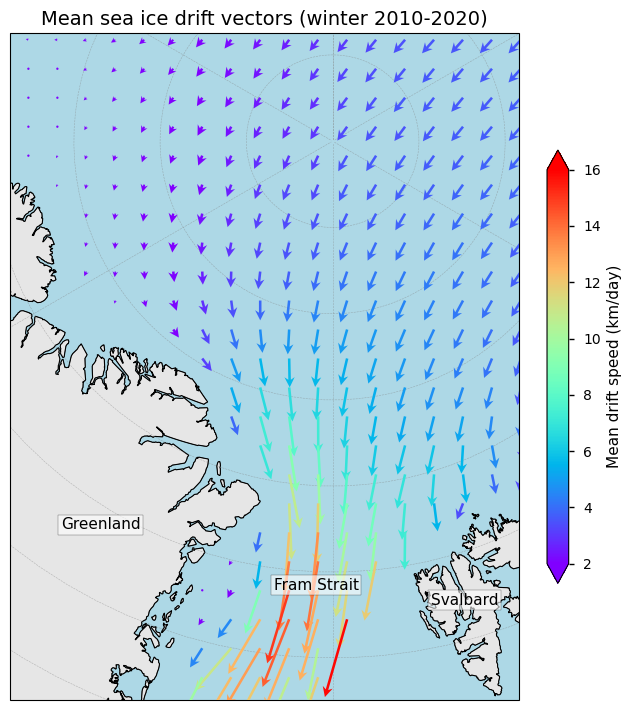

In [61]:
ds=datasets["satellite-sea-ice-drift"]
plot_mean_drift_arrows(ds)

*Figure 1. Average sea ice drift vectors across the Fram Strait region during the winter months (October to April) of the 2010-2020 period from the C3S data.*

The figure above illustrates the mean winter (October–April) sea ice drift field for 2010–2020, showing the dominant southward export of sea ice through Fram Strait. Drift speeds accelerate markedly as the Transpolar Drift Stream approaches the strait and sea ice gets squeezed in between Greenland and Svalbard. This persistent outflow illustrates Fram Strait’s role as the primary pathway for Arctic sea ice export towards the North Atlantic [[2](https://doi.org/10.5194/tc-12-3017-2018), [3](https://doi.org/10.5194/tc-13-3209-2019)].

(section-2-2)=
#### 2.2 Sea ice drift uncertainty

Let us now investigate the uncertainties of the sea ice drift data. We begin by plotting a time series of the reported uncertainties within the data `uncert_dX_and_dY`. The total error of a sea ice drift estimate is theoretically given by the sum of the precision (random) and the accuracy (systematic) error:

$
\varepsilon = a\sigma + \delta
$
where $a$ is the critical z-value related to a certain statistical confidence interval, $\sigma$ is the standard deviation (random error) and $\delta$ the accuracy (systematic) error. 

For the sea ice drift data, the product only deals with precision errors in the form of 1 standard deviation. In this case, the uncertainty can be expressed as $\sigma_D$.

A time series of the spatially averaged errors reveals the following overall values:

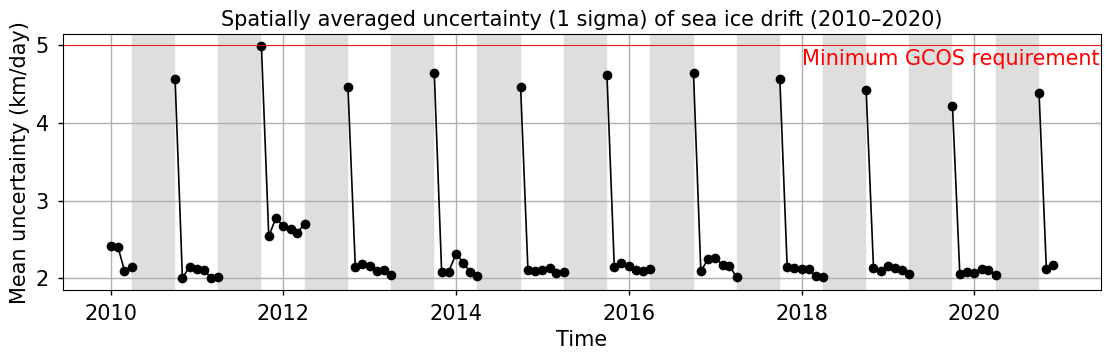

In [68]:
# Extract and spatially average drift uncertainty
da = datasets["satellite-sea-ice-drift"]["uncert_dX_and_dY"]
da = diagnostics.spatial_weighted_mean(da)

# Monthly means
da_monthly = da.resample(time="1MS").mean()

# Prepare the plot
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the uncertainty time series
line = da_monthly.plot(ax=ax, color="black", marker="o", lw=1.2)
ax.set_ylabel("Mean uncertainty (km/day)",fontsize=15)

# Shade summer periods (Apr–Oct)
time_index = da_monthly["time"].to_index()
year_start = time_index.min().year
year_stop  = time_index.max().year

for year in range(year_start, year_stop + 1):
    ax.axvspan(
        pd.to_datetime(f"{year}-04-01"),
        pd.to_datetime(f"{year}-10-01"),
        color="lightgrey",
        alpha=0.75,
        zorder=0,
    )

# Title
ax.set_title("Spatially averaged uncertainty (1 sigma) of sea ice drift (2010–2020)",fontsize=15)
ax.axhline(5, color="r", lw=0.6)
ax.text(time_index[-36], 4.75, "Minimum GCOS requirement", color="red",fontsize=15)
ax.grid(True)
ax.tick_params(axis="both", labelsize=15)
ax.set_xlabel("Time",fontsize=15)
plt.tight_layout()
plt.show()

*Figure 2. Spatially averaged sea ice drift uncertainty (expressed as 1 sigma precision errors) of the winter months (October-April) between 2010-2020 of the C3S data. Shaded intervals indicate the summer months, during which data are not calculated.*

The uncertainty assessment shows that overall errors are in the order of 2 to 2.5 km/day for the winter months. Given that the recommended GCOS "threshold" value (i.e. the minimum requirement to be met to ensure that data are useful) is 5 km/day in terms of 1 sigma, the data meet this requirement [[5](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)]. However, a characteristic that catches the eye in the above figure is the consistently higher uncertainty for the month October (in the order of 4-5 km/day). This is because the sea ice drift from satellite motion tracking may still be less reliable due to surface melting and increased atmospheric wetness [[1](https://doi.org/10.5194/essd-15-5807-2023)]. Let us now calculate the 2D field of these uncertainties:

In [69]:
def plot_mean_field(ds, varname, title=None, cmap=None, vmin=None, vmax=None):

    # Time-mean field 
    da = ds[varname].mean(dim="time", skipna=True)

    # Coordinates (km to m)
    x = ds["xc"].values * 1000
    y = ds["yc"].values * 1000

    # Colormap 
    if vmin is None:
        vmin = float(da.min())
    if vmax is None:
        vmax = float(da.max())

    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # Projection 
    proj = ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": proj})

    # Geographic extent
    lon_min, lon_max = -30, 90
    lat_min, lat_max = 70, 85

    xy_min = proj.transform_point(lon_min, lat_min, src_crs=ccrs.PlateCarree())
    xy_max = proj.transform_point(lon_max, lat_max, src_crs=ccrs.PlateCarree())
    ax.set_extent([xy_min[0], xy_max[0], xy_min[1], xy_max[1]], crs=proj)

    # Background
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", zorder=0)
    ax.add_feature(cfeature.LAND, facecolor="0.9", edgecolor="black", zorder=1)
    ax.coastlines(linewidth=0.8, zorder=2)

    # Plot gridded field 
    im = ax.pcolormesh(
        x, y, da.values,
        cmap=cmap,
        norm=norm,
        transform=proj,
        shading="auto",
        zorder=3,
    )

    ax.gridlines(draw_labels=False, linewidth=0.4, linestyle="--",
                 color="gray", alpha=0.5, zorder=100)

    # Colorbar 
    cb = fig.colorbar(im, ax=ax, shrink=0.65, pad=0.04, extend='both')
    cb.set_label("Mean drift uncertainty (km/day)")

    # Labels on map 
    ax.text(-9, 79.5, "Fram Strait", transform=ccrs.PlateCarree(), fontsize=11,
            bbox=dict(facecolor="white", edgecolor="black", alpha=0.6, pad=2))
    ax.text(-35, 79, "Greenland", transform=ccrs.PlateCarree(), fontsize=11,
            bbox=dict(facecolor="white", edgecolor="black", alpha=0.6, pad=2))
    ax.text(12, 79, "Svalbard", transform=ccrs.PlateCarree(), fontsize=11,
            bbox=dict(facecolor="white", edgecolor="black", alpha=0.6, pad=2))

    # Title 
    if title is None:
        title = f"Mean {varname}"
    ax.set_title(title, fontsize=14)

    plt.tight_layout()
    plt.show()


Let us now plot the 2D field of uncertainties with the above function:

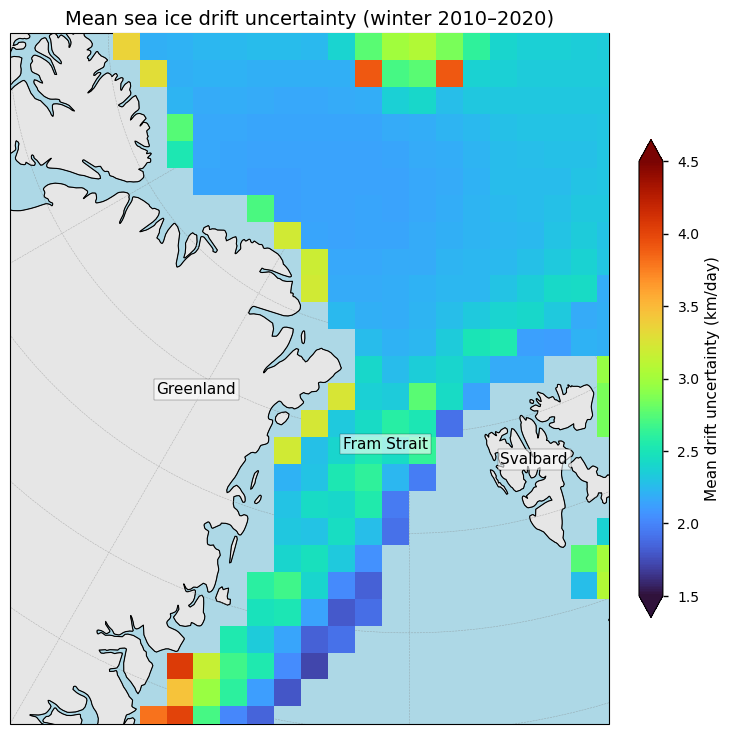

In [70]:
plot_mean_field(
    datasets["satellite-sea-ice-drift"],
    varname="uncert_dX_and_dY",
    title="Mean sea ice drift uncertainty (winter 2010–2020)",
    cmap="turbo",
    vmin=1.5,
    vmax=4.5
)

*Figure 3. Time-averaged sea ice drift uncertainty of the winter months (October-April) near the Fram Strait area between 2010-2020 of the C3S data.*

The above figure shows the spatial pattern of the time-averaged uncertainty related to the sea ice drift data near the Fram Strait area. Uncertainties are lowest north of Fram Strait over closed sea ice, but clearly increase toward the dynamically active export region with peak values along the Greenland margin and near the ice edge. Let us plot some statistics (i.e. its minimum, maximum and average value) of the error variable over the entire domain:

In [71]:
da = datasets['satellite-sea-ice-drift']['uncert_dX_and_dY']

mean_val = float(da.mean())
min_val  = float(da.min())
max_val  = float(da.max())

print(f"uncert_dX_and_dY -> mean: {mean_val:.4f} km/day, min: {min_val:.4f} km/day, max: {max_val:.4f} km/day")

uncert_dX_and_dY -> mean: 2.3066 km/day, min: 1.5718 km/day, max: 12.8355 km/day


This shows that a substantial variation is present in the uncertainty values data, but that the overall error meets the GCOS threshold of 5 km/day, as discussed before [[5](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)]. With this in mind, we can proceed to calculate the winter sea ice volume export through Fram Strait and its corresponding uncertainty.

(section-3)=
### 3. Calculating the winter sea ice volume export through Fram Strait between 2010-2020

(section-3-1)=
#### 3.1 Defining the location of the Fram Strait gate 

We define the gate as follows, which is a location similar to that of Ricker et al. (2018) [[2](https://doi.org/10.5194/tc-12-3017-2018)]. The meridional gate is located along 82°N between 12°W and 20°E. The zonal part is located along 20°E between 80.5°N and 82°N. Let us define a function that extracts pixels that define the gate:

In [72]:
def get_gate_pixels(ds):
    lat = ds["latitude"].values
    lon = ds["longitude"].values

    gate_mask_lat = (
        np.isclose(lat, 82.0, atol=0.4) &   # use wide tolerance for debugging
        (lon >= -14.0) &
        (lon <= 20.0)
    )
    gate_mask_lon = (
        (np.isclose(lon, 20.0, atol=2.0) | np.isclose(lon, 21.0, atol=2.0))
        &
        (lat >= 80.5) &
        (lat <= 82.0)
    )
        
    proj = ccrs.LambertAzimuthalEqualArea(central_longitude=0,
                                          central_latitude=90)

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": proj})

    # Extent in lon/lat
    lon_min, lon_max = -30, 80      # degrees
    lat_min, lat_max = 75, 85       # degrees

    proj = ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)

    xy_min = proj.transform_point(lon_min, lat_min, src_crs=ccrs.PlateCarree())
    xy_max = proj.transform_point(lon_max, lat_max, src_crs=ccrs.PlateCarree())

    xmin, ymin = xy_min
    xmax, ymax = xy_max
    ax.set_extent([xmin, xmax, ymin, ymax], crs=proj)

    # Land/ocean
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", zorder=0)
    ax.add_feature(cfeature.LAND, facecolor="0.9", edgecolor="black", zorder=1)
    ax.coastlines(linewidth=0.8, zorder=2)
    ax.gridlines(draw_labels=False, linewidth=0.4, linestyle="--",
                 color="gray", alpha=0.4)

    ax.scatter(
        lon[gate_mask_lat], lat[gate_mask_lat],
        transform=ccrs.PlateCarree(),
        color="red", s=60, zorder=10
    )
    ax.scatter(
        lon[gate_mask_lon], lat[gate_mask_lon],
        transform=ccrs.PlateCarree(),
        color="blue", s=60, zorder=10
    )

    #  Plot Fram Strait Gate: create geographic coordinate arrays
    lon_meridional = np.linspace(-12, 20, 200)    # 12°W to 20°E
    lat_meridional = np.full_like(lon_meridional, 82.0)  # constant 82°N
    lat_zonal = np.linspace(80.5, 82.0, 200)      # 80.5°N to 82°N
    lon_zonal = np.full_like(lat_zonal, 20.0)     # constant 20°E

    # Plot thick black lines
    ax.plot(
        lon_meridional, lat_meridional,
        color='black', linewidth=3,
        transform=ccrs.PlateCarree(), zorder=10
    )

    ax.plot(
        lon_zonal, lat_zonal,
        color='black', linewidth=3,
        transform=ccrs.PlateCarree(), zorder=10
    )

    # Construct legend
    meridional_proxy = plt.Line2D([], [], color='red', marker='o', linestyle='None',
                                  markersize=10, label='Meridional gate pixels')
    zonal_proxy = plt.Line2D([], [], color='blue', marker='o', linestyle='None',
                             markersize=10, label='Zonal gate pixels')

    # Add some text
    ax.text(-5, 81.25, "Fram Strait", transform=ccrs.PlateCarree(), fontsize=11, bbox=dict(facecolor="white", edgecolor="black", alpha=0.6, pad=2))
    ax.text(-35, 79, "Greenland", transform=ccrs.PlateCarree(), fontsize=11, bbox=dict(facecolor="white", edgecolor="black", alpha=0.6, pad=2))
    ax.text(12, 79, "Svalbard", transform=ccrs.PlateCarree(), fontsize=11, bbox=dict(facecolor="white", edgecolor="black", alpha=0.6, pad=2))
    
    ax.legend(handles=[meridional_proxy, zonal_proxy],
              loc="upper right",
              fontsize=11,
              frameon=True,
              facecolor="white",
              edgecolor="black")

    plt.title("Gate pixels Fram Strait", fontsize=14)
    plt.show()

    return gate_mask_lat, gate_mask_lon

Now we can plot those pixels:

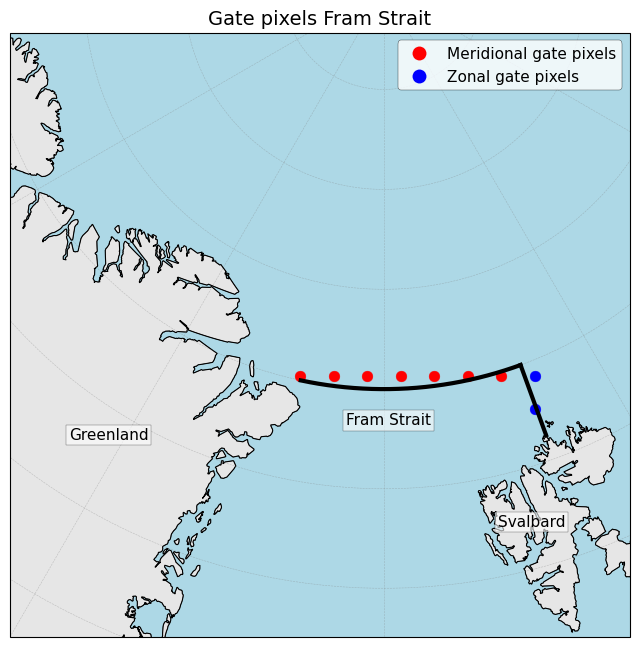

In [73]:
gate_mask_lat, gate_mask_lon = get_gate_pixels(datasets["satellite-sea-ice-drift"])

*Figure 4. The pixels that define the gate through which the sea ice volume flux is calculated. Note that the gate pixels and the actual gate are not aligned, implying that a correction has to be applied to the data to calculate the fluxes in geographic space. The black lines follow the 82°N parallel and 20°E meridian, while the points denote the corresponding pixels that define the gate within the equal area projection grid.*

These gate pixels are similar to the gate defined in Ricker et al. (2018) and Min et al. (2019) [[2](https://doi.org/10.5194/tc-12-3017-2018), [3](https://doi.org/10.5194/tc-13-3209-2019)]. We can now calculate the sea ice volume export through this gate by combining the C3S sea ice drift data with C3S ice thickness and ice concentration data.

(section-3-2)=
#### 3.2 Calculating winter sea ice export through the Fram Strait

The sea ice volume flux transported through the defined gate is calculated by addressing the zonal and meridional part of the gate, similar to the procedure in Ricker et al. (2018) [[2](https://doi.org/10.5194/tc-12-3017-2018)].

For the meridional part, this implies:

$ Q_V = L * H * C * D_V $ [km$^3$  month$^{-1}$]

where:

$L$ = the length of the grid cell along the gate in geographic space, which depends on the longitude within the projected grid,

$H*C$ = the effective sea ice thickness, as the product of the sea ice thickness $H$ and sea ice concentration $C$,

$D_V$ = the meridional component of the sea ice drift.

The procedure is similar for the zonal component $Q_U$:

$ Q_U = L * H * C * D_U $ [km$^3$  month$^{-1}$]

Due to the grid projection (i.e. the equal area projection accurately represents area in all regions of the sphere, but it does not accurately represent other geometrical properties, such as angles, in geographic space) and the fact that the gates are not aligned with the grid, a correction has to be applied to the data to calculate the flux components. 

The drift components have to be corrected with respect to the difference between the grid angle and the true north and east:

$D_V = D_x * sin(\lambda) - D_y * cos(\lambda)$, and

$D_U = D_x * cos(\lambda) + D_y * sin(\lambda)$

Also the gate length has to be corrected:

$L = \dfrac{\Delta y}{cos(\lambda)}$ = $\dfrac{\Delta x}{cos(\lambda)}$

Here, $\lambda$ is the longitude of the grid cell. The final total export is then calculated as:

$Q_{gate} = \sum\limits^{time} \sum\limits^{gate} Q_V + \sum\limits^{time} \sum\limits^{gate} Q_U$

Let us now perform this calculation:

In [74]:
# Define variables
ds_drift = datasets["satellite-sea-ice-drift"]
ds_sit   = datasets["satellite-sea-ice-thickness"]
ds_conc  = datasets["satellite-sea-ice-concentration"]

# Align in time and space 
ds_drift, ds_sit, ds_conc = xr.align(ds_drift, ds_sit, ds_conc, join="inner")

# Monthly displacements along the x,y directions (km/month)
Dx = ds_drift["dX_sum"]      # (time, yc, xc)
Dy = ds_drift["dY_sum"]

# Sea ice concentration (fraction 0–1)
C  = ds_conc["ice_conc"] / 100.0

# Sea ice thickness (m)
H  = ds_sit["sea_ice_thickness"] / 1000.0   # m to km

# Effective thickness H*C in km
H_eff_km = (H * C) 

# Geographic longitude (degrees) and radians
lon_deg = ds_drift["longitude"]
lam = np.deg2rad(lon_deg)     # longitude in radians, same shape as grid

# Grid spacing in km (from xc,yc)
dx_nom = float(ds_drift["xc"].diff("xc").mean())   # km
dy_nom = float(ds_drift["yc"].diff("yc").mean())   # km

# Meridional (v) and zonal (u) components in geographic space, km/month
Dv = Dx * np.sin(lam) - Dy * np.cos(lam)
Du = Dx * np.cos(lam) + Dy * np.sin(lam)

# Avoid division by zero 
coslam = np.cos(lam)
coslam = xr.where(coslam == 0, np.nan, coslam)

# Grid cell lengths
Lv = dy_nom / coslam    # km, meridional gate segments
Lu = dx_nom / coslam    # km, zonal gate segments

# Volume fluxes
Qv_cell = Lv * H_eff_km * Dv    # (time, yc, xc) km³/month
Qu_cell = Lu * H_eff_km * Du

# Get gates
gate_mask_lat = xr.DataArray(
    gate_mask_lat, 
    dims=("yc", "xc"),
    coords={"yc": ds_drift.yc, "xc": ds_drift.xc}
)

gate_mask_lon = xr.DataArray(
    gate_mask_lon, 
    dims=("yc", "xc"),
    coords={"yc": ds_drift.yc, "xc": ds_drift.xc}
)

gate_mask_lat = gate_mask_lat.expand_dims(time=ds_drift.time).transpose("yc", "xc", "time")
gate_mask_lon = gate_mask_lon.expand_dims(time=ds_drift.time).transpose("yc", "xc", "time")

# Meridional part (only gate_mask_lat pixels)
Qv_gate = Qv_cell.where(gate_mask_lat).sum(dim=("yc", "xc"), skipna=True)

# Zonal part (only gate_mask_lon pixels)
Qu_gate = Qu_cell.where(gate_mask_lon).sum(dim=("yc", "xc"), skipna=True)

# Total export through Fram Strait gate
Q_total = Qv_gate + Qu_gate       # 1D over time, km³/month

With the calculation performed, we can now plot the data as a time series:

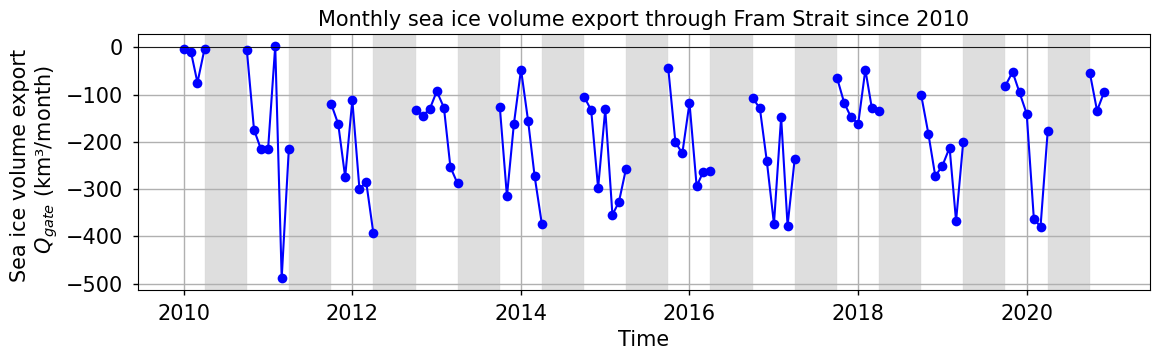

In [75]:
# Extract and prepare volume export time series
Q_monthly = Q_total.resample(time="1MS").sum()   

# Mask only winter months (Oct–Apr)
winter_mask = Q_monthly["time"].dt.month.isin([10, 11, 12, 1, 2, 3, 4])
Q_winter = Q_monthly.where(winter_mask)

# Prepare plot
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the time series 
Q_winter.plot(ax=ax, color="blue", marker="o", lw=1.5)

ax.set_ylabel(
    "Sea ice volume export \n $Q_{gate}$ (km³/month)",
    fontsize=15
)
ax.set_xlabel("Time",fontsize=15)

# Title
ax.set_title("Monthly sea ice volume export through Fram Strait since 2010",fontsize=15)

# Shade summer periods (Apr–Oct)
time_index = Q_monthly["time"].to_index()
year_start = time_index.min().year
year_stop  = time_index.max().year

for year in range(year_start, year_stop + 1):
    ax.axvspan(
        pd.to_datetime(f"{year}-04-01"),
        pd.to_datetime(f"{year}-10-01"),
        color="lightgrey",
        alpha=0.75,
        zorder=0
    )

# Horizontal zero line
ax.axhline(0, color="k", lw=0.6)

# Grid and layout
ax.grid(True)
ax.tick_params(axis="both", labelsize=15)
plt.tight_layout()
plt.show()


*Figure 5. Monthly sea ice volume export through Fram Strait obtained with C3S sea ice data. Here, we define negative values as outflow or export by convention. Shaded intervals indicate the summer months, during which data are not calculated.*

The monthly sea ice volume export through Fram Strait derived from the C3S dataset exhibits substantial variability over the 2010–2020 period, with typical winter outflow rates ranging between approximately −100 and −400 km³ per month (with negative values indicating outflow or export by convention). Occasional extreme events occur, such as during March 2011, reflecting periods of strong ice drift and enhanced sea ice transport. The time series, in this notebook only spanning 10 years, shows some clear variability but no obvious long term trend, indicating that short-term atmospheric/oceanic forcing and seasonal ice conditions dominantly control the volume flux through Fram Strait during this time frame.

(section-3-3)=
#### 3.3 Comparison of sea ice volume export with CMST data

To evaluate the robustness of our calculated sea ice volume export, we compare our results with an independent dataset. Specifically, we use sea ice volume fluxes derived from the CMST product of Min et al. (2019) [[3](https://doi.org/10.5194/tc-13-3209-2019)]. The CMST (Combined Model and Satellite sea ice Thickness) dataset generates spatio-temporal sea ice thickness fields in the Arctic and is produced with an Arctic regional ice–ocean model that assimilates remote sensing-derived values of sea ice thickness and concentration. In this system, grid cell-averaged sea ice thickness evolves according to the modelled thermodynamic growth and melt of sea ice and the sea ice flux divergence. Sea ice drift is needed to calculate these flux divergences, and is hence a byproduct of the model output. It is determined by the balance of internal ice stresses and wind and oceanic forcing [[4](https://doi.org/10.1029/2018JC014316)]. Because the CMST framework provides modelled fields of ice drift, thickness, and concentration, its sea ice volume flux through Fram Strait offers an independent reference against which we compare our OSI SAF–based estimates. 

Let us plot the comparison with data extracted from Min et al. (2019):

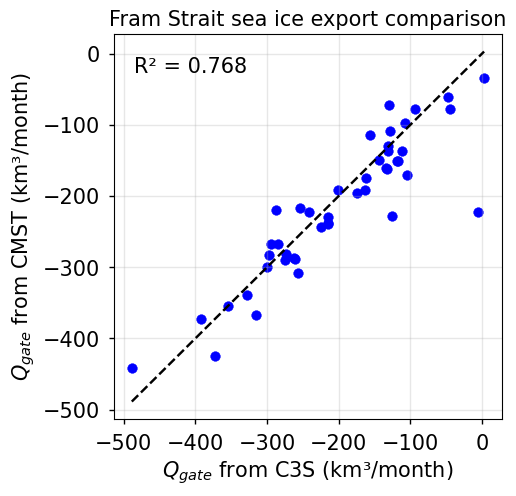

In [76]:
# CMST reference volume export from Min et al. (2019)
Q_CMST = np.array([
    -222, -195, -239, -238, -34, -442, -230, -151, -175, -290,
    -137, -300, -267, -372, -160, -149, -136, -78, -109, -217,
    -219, -228, -367, -191, -61, -114, -282, -425, -170, -162,
    -283, -129, -355, -339, -308, -78, -192, -244, -150, -267,
    -287, -289, -97, -72, -222
])

# Total export from OSI SAF (C3S)
Q_valid = Q_winter.dropna(dim="time").isel(time=slice(4, 49))

# Scatter comparison
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(Q_valid.values, Q_CMST, c="blue", alpha=1)

# 1:1 line
xymin = min(Q_valid.min(), Q_CMST.min())
xymax = max(Q_valid.max(), Q_CMST.max())
ax.plot([xymin, xymax], [xymin, xymax], "k--", label="1:1 line")

# R²
R2 = r2_score(Q_CMST, Q_valid.values)
ax.text(0.05, 0.9, f"R² = {R2:.3f}", transform=ax.transAxes, fontsize=15)

ax.set_xlabel("$Q_{gate}$ from C3S (km³/month)",fontsize=15)
ax.set_ylabel("$Q_{gate}$ from CMST (km³/month)",fontsize=15)
ax.set_title("Fram Strait sea ice export comparison",fontsize=15)
ax.tick_params(axis="both", labelsize=15)
ax.grid(alpha=0.3)
plt.show()

*Figure 6. Comparison of C3S monthly sea ice volume export through Fram Strait with estimates from CMST data. The dashed line is the 1:1 line.*

The comparison between monthly sea ice volume export through Fram Strait derived from C3S and CMST data shows a strong relationship, with an R$^2$
= 0.768. Most data points cluster close to the 1:1 line, indicating that both products capture the variability and magnitude of the export fluxes reasonably well. The overall agreement demonstrates that the C3S retrievals provide a robust representation of monthly sea ice-related variables.

(section-3-4)=
#### 3.4 Sea ice volume export uncertainty

To calculate the uncertainty with respect to the sea ice volume export, we follow the procedure in Ricker et al. (2018) [[2](https://doi.org/10.5194/tc-12-3017-2018)]. This study expresses the pixel-by-pixel volume flux error estimate according to the law of error propagation. For a certain pixel $i$, this implies:

${\sigma_{Q,i}} = L \sqrt{(HC{\sigma_D})^2 + (HD\sigma_C)^2 + (DC\sigma_H)^2}$

with $L$ the gate length, $H$ the sea ice thickness, $C$ the sea ice concentration, and $D$ the sea ice drift on a monthly basis. These symbols are also used as a subscript to express their corresponding uncertainty $\sigma$.

We furthermore assume that the monthly errors are uncorrelated in neither space nor time. This implies that, in order to calculate the monthly uncertainties of the sea drift data from the daily values, we take the square root of the sum of squares across all days within a month in a certain pixel:

${\sigma_D} = \sqrt{\sum\limits^{N}_{d=1}{(\sigma_{D,d})^2}}$

with $N$ the number of days in a month and $\sigma_{D,d}$ is the `uncert_dX_and_dY` variable for a certain day. Because a single uncertainty estimate is given per vector, we assume that $\sigma_{D_V} = \sigma_{D_U}$. 

We then calculate the total monthly volume flux uncertainty through all pixels of the gate as:

${{\sigma_Q}_{gate}} = \sqrt{\sum\limits^{M}_{i=1}{(\sigma_{Q,i})^2}}$

where $M$ is the number of gate pixels.

In [77]:
# Load aligned datasets
ds_drift = datasets["satellite-sea-ice-drift"]
ds_sit   = datasets["satellite-sea-ice-thickness"]
ds_conc  = datasets["satellite-sea-ice-concentration"]

ds_drift, ds_sit, ds_conc = xr.align(ds_drift, ds_sit, ds_conc, join="inner")

# Load variables
# Drift components (km/month)
Dx = ds_drift["dX_sum"]
Dy = ds_drift["dY_sum"]

# Drift uncertainty (km/month)
sigma_D = ds_drift["uncert_dX_and_dY_sum"]

# SIT (m) and SIT uncertainty (m)
H = ds_sit["sea_ice_thickness"] / 1000.0   # m to km
sigma_H = ds_sit["uncertainty"] / 1000.0   # m to km

# Concentration (fraction 0–1) and uncertainty (fraction)
C = ds_conc["ice_conc"] / 100.0
sigma_C = ds_conc["total_standard_uncertainty"] / 100.0

# Grid geometry 
lon_deg = ds_drift["longitude"]
lam = np.deg2rad(lon_deg)

dx_nom = float(ds_drift["xc"].diff("xc").mean())
dy_nom = float(ds_drift["yc"].diff("yc").mean())

coslam = np.cos(lam)
coslam = xr.where(coslam == 0, np.nan, coslam)

# Meridional / zonal geometric lengths
Lv = dy_nom / coslam     # km
Lu = dx_nom / coslam     # km

# Geographic drift components (km/month)
Dv = Dx * np.sin(lam) - Dy * np.cos(lam)
Du = Dx * np.cos(lam) + Dy * np.sin(lam)

# Pixel level uncertainty 
# Meridional uncertainty 
term1_v = (H * C * sigma_D)**2
term2_v = (Dv * C * sigma_H)**2
term3_v = (H * Dv * sigma_C)**2

sigma_Qv_cell = Lv * np.sqrt(term1_v + term2_v + term3_v) 

# Zonal uncertainty
term1_u = (H * C * sigma_D)**2
term2_u = (Du * C * sigma_H)**2
term3_u = (H * Du * sigma_C)**2

sigma_Qu_cell = Lu * np.sqrt(term1_u + term2_u + term3_u) 

# Apply gate masks (time,yc,xc)
sigma_Qv_gate_pixels = sigma_Qv_cell.where(gate_mask_lat)
sigma_Qu_gate_pixels = sigma_Qu_cell.where(gate_mask_lon)

# Total monthly export uncertainty 
sigma_Q_total = np.sqrt(
    (sigma_Qv_gate_pixels**2).sum(dim=("yc","xc"), skipna=True)
  + (sigma_Qu_gate_pixels**2).sum(dim=("yc","xc"), skipna=True)
)


Let us plot a time series of this data:

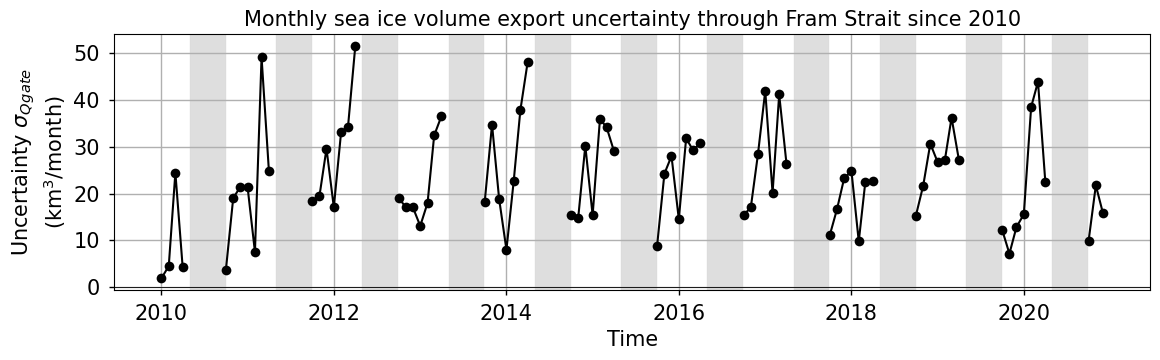

In [78]:
# Monthly uncertainty time series
sigma_monthly = sigma_Q_total.resample(time="1MS").mean()

# Mask only winter months (Oct–Apr)
winter_mask = sigma_monthly["time"].dt.month.isin([10, 11, 12, 1, 2, 3, 4])
sigma_winter = sigma_monthly.where(winter_mask)

# Prepare plot
fig, ax = plt.subplots(figsize=(12, 4))

# Plot winter-only values 
sigma_winter.plot(ax=ax, color="black", marker="o", lw=1.5)

ax.set_ylabel(
    r"Uncertainty ${\sigma_Q}_{gate}$" "\n" r"(km$^3$/month)",
    fontsize=15
)
ax.set_xlabel("Time",fontsize=15)
ax.set_title("Monthly sea ice volume export uncertainty through Fram Strait since 2010",fontsize=15)

# Shade summer periods (May–September)
time_index = sigma_monthly["time"].to_index()
year_start = time_index.min().year
year_stop  = time_index.max().year

for year in range(year_start, year_stop + 1):
    ax.axvspan(
        pd.to_datetime(f"{year}-05-01"),
        pd.to_datetime(f"{year}-09-30"),
        color="lightgrey",
        alpha=0.75,
        zorder=0
    )

# Horizontal zero line
ax.axhline(0, color="k", lw=0.6)

# Final styling
ax.grid(True)
ax.tick_params(axis="both", labelsize=15)
plt.tight_layout()
plt.show()


*Figure 7. Monthly sea ice volume export uncertainties through Fram Strait obtained with C3S sea ice data. Shaded intervals indicate the summer months, during which data are not calculated.*

Or when plotted as error bars on top of the actual data:

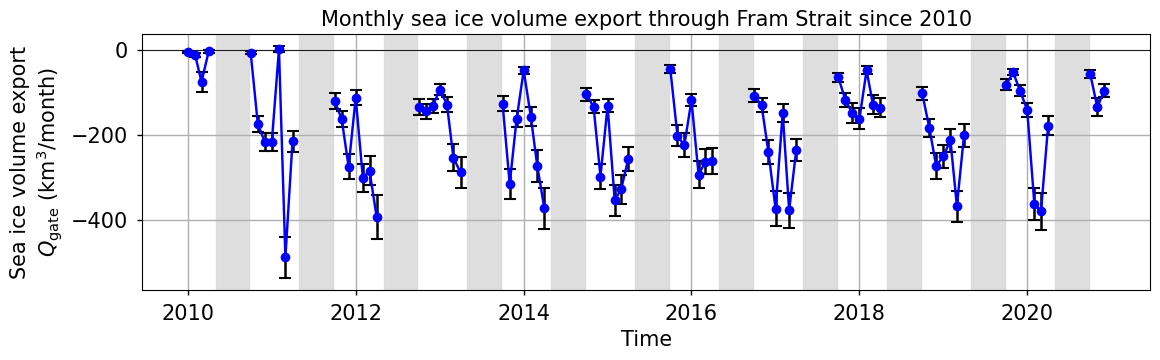

In [79]:
# Monthly resampled export + uncertainty
Q_monthly     = Q_total.resample(time="1MS").sum()
sigma_monthly = sigma_Q_total.resample(time="1MS").mean()

# Winter-only (Oct–Apr)
winter_mask = Q_monthly["time"].dt.month.isin([10, 11, 12, 1, 2, 3, 4])
Q_winter     = Q_monthly.where(winter_mask)
sigma_winter = sigma_monthly.where(winter_mask)

time_index = Q_monthly["time"].to_index()

# Set up figure
fig, ax = plt.subplots(figsize=(12, 4))

# Zero line
ax.axhline(0, color="k", lw=0.6)

# Plot with error bars
ax.errorbar(
    time_index,
    Q_winter,
    yerr=sigma_winter,
    fmt="-o",
    color="blue",
    ecolor="black",
    elinewidth=1.8,
    capsize=4,
    capthick=1.5,
    alpha=1
)

ax.set_ylabel(
    r"Sea ice volume export" "\n" r"$Q_{\mathrm{gate}}$ (km$^3$/month)",
    fontsize=15,
)
ax.set_xlabel("Time",fontsize=15)
ax.set_title("Monthly sea ice volume export through Fram Strait since 2010",fontsize=15)

# Shade summer months (May–September)
year_start = time_index.min().year
year_stop  = time_index.max().year

for year in range(year_start, year_stop + 1):
    ax.axvspan(
        pd.to_datetime(f"{year}-05-01"),
        pd.to_datetime(f"{year}-09-30"),
        color="lightgrey",
        alpha=0.75,
        zorder=0
    )

# Final styling
ax.grid(True)
ax.tick_params(axis="both", labelsize=15)
plt.tight_layout()
plt.show()

*Figure 8. Monthly sea ice volume export magnitudes through Fram Strait, together with their uncertainties shown as error bars, as obtained with the C3S sea ice data. Shaded intervals indicate the summer months, during which data are not calculated.*

The error bars in the time series above illustrate the month-to-month uncertainty in the estimated sea ice volume export. Uncertainties typically range between roughly 10 and 50 km³ month⁻¹. The uncertainty varies over the record, which reflects changes in the quality of the underlying satellite observations. Overall, the magnitude of the error bars indicates that uncertainty represents a significant but not dominant fraction of the export signal, and that the C3S sea ice dataset quality is hence satisfactory. Moreover, since the uncertainty of the sea ice drift data are within acceptable GCOS bounds, as discussed earlier, the resulting volume export estimates can be considered robust. The error magnitude is not large enough to alter the overall variability or seasonal pattern of the export time series.

(section-4)=
### 4. Short summary and take-home messages

To be able to label a sea ice-related dataset as "quality rich" and for climate change analysis/monitoring to become reliable and possible, the dataset should at least exhibit a comprehensive spatial coverage (i.e. hemispheric), a long and continuous temporal coverage (> 30 years), quantified and transparent pixel-by-pixel uncertainty estimates that meet international proposed thresholds, a validation effort or a comparison to (theoretical) models, and an adequate spatio-temporal resolution (cfr. the "Maturity Matrix" [[6](https://doi.org/10.1175/BAMS-D-21-0109.1)]). 

The C3S sea ice drift dataset provides daily, pixel-by-pixel estimates of sea ice drift, together with associated quality flags and quantitative uncertainty estimates in the form of 1 sigma precision errors. In this notebook, the dataset was combined with C3S satellite-derived sea ice concentration and sea ice thickness products to compute the monthly sea ice volume export through Fram Strait. Therefore, all data were regridded and resampled to a common spatial and temporal frame. Quality-wise, it can therefore be stated that the spatial/temporal extent, the temporal resolution and the uncertainty characteristics of the sea ice drift product meet proposed GCOS requirements, implying a quality rich dataset with respect to those aspects [[5](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)]. Certain regions, such as coastal areas and the sea ice edge, are prone to slightly higher uncertainty values. In these regions, difficulties with respect to data retrieval and acquisition may imply data of slightly lesser quality. Moreover, the spatial resolution of 75 km remains slightly too coarse with respect to internationally proposed thresholds. Despite these minor limitations, the resulting sea ice volume export estimates show good agreement with independent CMST-derived fluxes, indicating that the C3S sea ice drift product is sufficiently robust and credible for large-scale sea ice transport studies.

We further note, however, that this notebook deals with only a specific subset of the sea ice drift data, i.e. for the Fram Strait region and for the winter months of 2010-2020. This was done due to constraints of other C3S sea ice products, as well as to align the data with the temporal window of independent data reported in the literature [[3](https://doi.org/10.5194/tc-13-3209-2019)]. The full dataset spans a broader spatial and temporal extent.

## ℹ️ If you want to know more

### Key resources

- ["Sea ice drift daily gridded data derived from satellite observations
"](https://cds.climate.copernicus.eu/datasets/satellite-sea-ice-drift?tab=overview) on the CDS
- [Documentation on the CDS](https://cds.climate.copernicus.eu/datasets/satellite-sea-ice-drift?tab=documentation) (Copernicus Knowledge Base).
- [Copernicus climate change indicators: sea ice](https://climate.copernicus.eu/climate-indicators/sea-ice)
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control` prepared by [B-Open](https://www.bopen.eu).

### References

- [[1](https://doi.org/10.5194/essd-15-5807-2023)] Lavergne, T. and Down, E. (2023). A climate data record of year-round global sea-ice drift from the EUMETSAT Ocean and Sea Ice Satellite Application Facility (OSI SAF), Earth Syst. Sci. Data, 15, 5807–5834, https://doi.org/10.5194/essd-15-5807-2023
  
- [[2](https://doi.org/10.5194/tc-12-3017-2018)] Ricker, R., Girard-Ardhuin, F., Krumpen, T., and Lique, C. (2018). Satellite-derived sea ice export and its impact on Arctic ice mass balance, The Cryosphere, 12, 3017–3032, https://doi.org/10.5194/tc-12-3017-2018

- [[3](https://doi.org/10.5194/tc-13-3209-2019)] Min, C., Mu, L., Yang, Q., Ricker, R., Shi, Q., Han, B., Wu, R., and Liu, J. (2019). Sea ice export through the Fram Strait derived from a combined model and satellite data set, The Cryosphere, 13, 3209–3224, https://doi.org/10.5194/tc-13-3209-2019

- [[4](https://doi.org/full/10.1029/2018JC014316)] Mu, L., Losch, M., Yang, Q., Ricker, R., Losa, S. N., and Nerger, L. (2018). Arctic-Wide Sea Ice Thickness Estimates From Combining Satellite Remote Sensing Data and a Dynamic Ice-Ocean Model with Data Assimilation During the CryoSat-2 Period, J. Geophys. Res-Oceans, 123, 7763–7780, https://doi.org/10.1029/2018JC014316

- [[5](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)] GCOS (Global Climate Observing System) (2022). The 2022 GCOS ECVs Requirements (GCOS-245). World Meteorological Organization: Geneva, Switzerland. doi: https://library.wmo.int/idurl/4/58111

- [[6](https://doi.org/10.1175/BAMS-D-21-0109.1)] Yang, C. X., Cagnazzo, C., Artale, V., Nardelli, B. B., Buontempo, C., Busatto, J., Caporaso, L., Cesarini, C., Cionni, I., Coll, J., Crezee, B., Cristofanelli, P., de Toma, V., Essa, Y. H., Eyring, V., Fierli, F., Grant, L., Hassler, B., Hirschi, M., Huybrechts, P., Le Merle, E., Leonelli, F. E., Lin, X., Madonna, F., Mason, E., Massonnet, F., Marcos, M., Marullo, S., Muller, B., Obregon, A., Organelli, E., Palacz, A., Pascual, A., Pisano, A., Putero, D., Rana, A., Sanchez-Roman, A., Seneviratne, S. I., Serva, F., Storto, A., Thiery, W., Throne, P., Van Tricht, L., Verhaegen, Y., Volpe, G., and Santoleri, R. (2022). Independent Quality Assessment of Essential Climate Variables: Lessons Learned from the Copernicus Climate Change Service, B. Am. Meteorol. Soc., 103, E2032–E2049, https://doi.org/10.1175/Bams-D-21-0109.1 